# **Projet :Prévision de consommation d'éléctricité**

**Partie 2 : Correction de la consommation**

**1. Pourquoi faire la correction de consommation**

La consommation d’énergie dépend fortement de la météo (surtout la température).
Pour pouvoir comparer deux périodes ou mesurer l’effet d’une action d’efficacité énergétique, il faut enlever l’influence de la température afin que les écarts observés ne soient pas dus à un hiver plus froid ou un été plus chaud.
La correction permet donc de :

* Neutraliser l’effet météo (variabilité exogène).

* Mettre en évidence les vraies évolutions : économies d’énergie, anomalies, tendances de fond.

* Construire une base de référence fiable pour le suivi énergétique.

**2.Comment faire la correction (méthode et formule)**

Étapes :

1- Modéliser la consommation en fonction de la température avec une régression linéaire :

Consommation = a + b * Température + ε

2-Estimer les coefficients a1 et b1 à partir des données historiques.

3- Corriger chaque observation en ramenant la température à une valeur de référence (souvent la température moyenne de la période) :

Consommation_corrigeé=Consommation_observeé - b1 *(Tempeérature_observeé−Tempeérature_moyenne)


Résultat : chaque valeur représente la consommation "comme si" la température avait été moyenne.

**3. Utilité de la correction**

Comparaison équitable entre différentes périodes (indépendamment de la météo).

Évaluation fiable des économies d’énergie après un projet (rénovation, changement d’équipement).

Détection d’anomalies de consommation non liées à la météo.

Élaboration de prévisions plus robustes (séparation effet météo / autres facteurs).

**4. Tests pour valider la méthode**

Pour s’assurer que la correction est pertinente, il faut :

* Vérifier la significativité statistique de b1 (p-value faible).
* Examiner le R² : il doit être suffisamment élevé pour confirmer que la température explique une part importante de la consommation.

* Analyser les résidus : ils doivent être centrés autour de zéro, sans tendance, et idéalement sans autocorrélation.

* Comparer avant/après correction : la variabilité due aux températures extrêmes doit diminuer visuellement (courbe plus lissée).

In [153]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot

In [154]:
df=pd.read_csv("df.csv")
df.head()

,Mois,Consommation totale,dju_chauffage
0,2012-01-01,51086,336.0
1,2012-02-01,54476,435.9
2,2012-03-01,43156,201.9
3,2012-04-01,40176,230.3
4,2012-05-01,35257,83.3


In [155]:
df.set_index("Mois",inplace=True)
df.index = pd.to_datetime(df.index)

In [156]:


# 1) Préparer X et y pour la régression (avec constante pour statsmodels)
y = df["Consommation totale"]
X = sm.add_constant(df['dju_chauffage'])

# 2) Ajuster la régression linéaire avec statsmodels
model_reg = sm.OLS(y, X).fit()

# 3) Extraire le coefficient β1
b1 = model_reg .params['dju_chauffage']

# 4) Calculer la consommation corrigée
dju_moy = df['dju_chauffage'].mean()
df['conso_corr'] = df['Consommation totale'] - b1 * (df['dju_chauffage'] - dju_moy)

# 5) Vérifier le résultat
print(f"Coefficient β1 = {b1:.3f}")
print(f"DJU moyen = {dju_moy:.3f}")
print(df[['Consommation totale', 'dju_chauffage', 'conso_corr']].head())


Coefficient β1 = 48.492
DJU moyen = 174.596
            Consommation totale  dju_chauffage    conso_corr
Mois                                                        
2012-01-01                51086          336.0  43259.231509
2012-02-01                54476          435.9  41804.889062
2012-03-01                43156          201.9  41831.997497
2012-04-01                40176          230.3  37474.827072
2012-05-01                35257           83.3  39684.138781


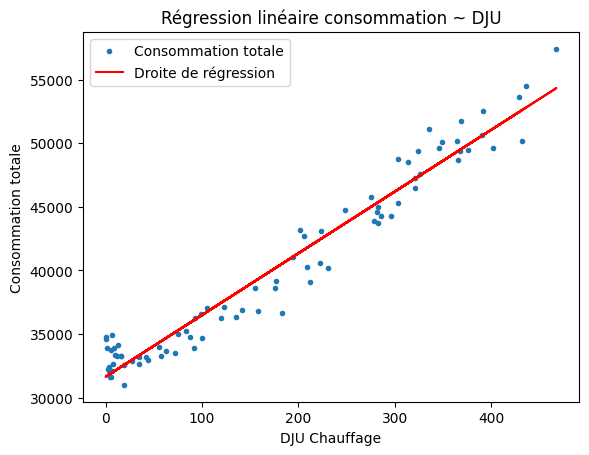

In [157]:
# 6) Tracer les points et la droite de régression
df.plot(x='dju_chauffage', y='Consommation totale', style='.', legend=False)
plt.plot(df['dju_chauffage'], model_reg .predict(X), color='red', label='Droite de régression')
# 7) Ajouter titres et labels
plt.xlabel('DJU Chauffage')
plt.ylabel('Consommation totale')
plt.title('Régression linéaire consommation ~ DJU')
plt.legend()
plt.show()

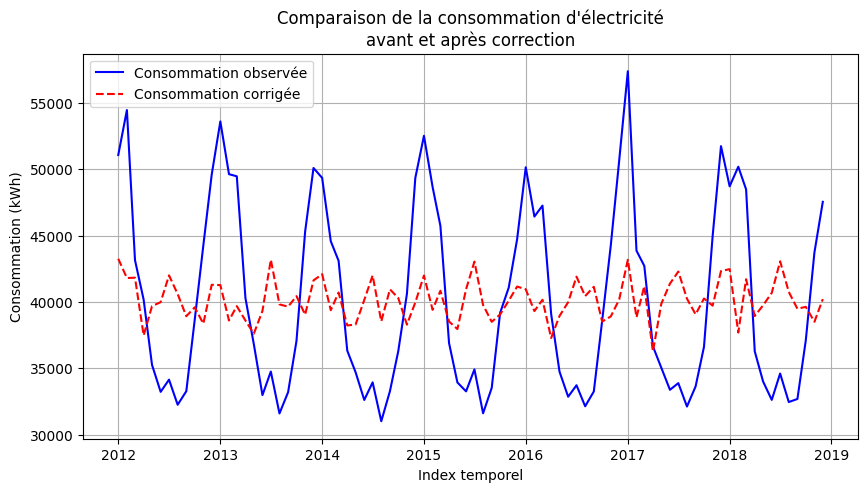

In [158]:
plt.figure(figsize=(10,5))
plt.plot(df["Consommation totale"], label='Consommation observée', color='blue')
plt.plot(df["conso_corr"], label='Consommation corrigée', color='red', linestyle='--')

plt.title("Comparaison de la consommation d'électricité\navant et après correction")
plt.xlabel("Index temporel")
plt.ylabel("Consommation (kWh)")
plt.legend()
plt.grid()

plt.show()


/usr/local/lib/python3.12/dist-packages/statsmodels/graphics/gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


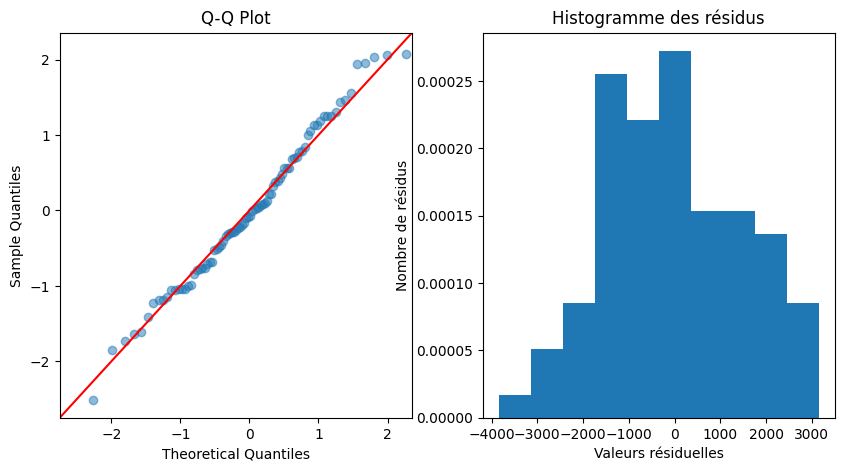

In [160]:


#Distribution des résidus
fig, ax = plt.subplots(1, 2, figsize=(10,5))

plt.hist(model_reg .resid, density=True)

model_norm_residuals = model_reg .get_influence().resid_studentized_internal
QQ = ProbPlot(model_norm_residuals)
QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', ax=ax[0])

ax[0].set_title('Q-Q Plot')
ax[1].set_title('Histogramme des résidus')
ax[1].set_xlabel('Valeurs résiduelles')
ax[1].set_ylabel('Nombre de résidus')

plt.show()

In [161]:
print(model_reg.summary())


                             OLS Regression Results                            
Dep. Variable:     Consommation totale   R-squared:                       0.954
Model:                             OLS   Adj. R-squared:                  0.954
Method:                  Least Squares   F-statistic:                     1704.
Date:                 Mon, 15 Sep 2025   Prob (F-statistic):           1.23e-56
Time:                         11:49:36   Log-Likelihood:                -734.60
No. Observations:                   84   AIC:                             1473.
Df Residuals:                       82   BIC:                             1478.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.164e+04    265.008 

* La consommation totale est fortement expliquée par les degrés-jours de chauffage (R² = 0,954).

* Chaque degré-jour de chauffage supplémentaire augmente la consommation d’environ 48,5 unités.

* Le modèle est très significatif (p < 0,001) et les résidus semblent normaux et indépendants.

* L’intercept indique que, sans degrés-jours de chauffage, la consommation serait d’environ 31 640 unités.

Conclusion : La variable dju_chauffage est un excellent prédicteur de la consommation totale.